In [5]:
import pandas as pd
import numpy as np
from numpy import linalg as LA
import scipy.io
import random
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
import ast
from sklearn import metrics

Load in the datasets and make all lower case:

In [6]:
Gold= pd.read_csv('Goldstandard.csv')
Gold=Gold.dropna()
Gold['Drug name']=Gold['Drug name'].str.lower()
Gold['Disease name']=Gold['Disease name'].str.lower()

mimtitles=pd.read_csv('mimTitles.csv')
mimtitles=mimtitles.rename(columns={'# Copyright (c) 1966-2022 Johns Hopkins University. Use of this file adheres to the terms specified at https://omim.org/help/agreement':'x'})
mimtitles['x']=mimtitles['x'].str.lower()

AllStructures= pd.read_csv('structure links.csv')
AllStructures=AllStructures.rename(columns={"Name": "Drug name"})
AllStructures['Drug name']=AllStructures['Drug name'].str.lower()

mat = scipy.io.loadmat('attempt.mat') 
MimMiner=mat['MimMiner']

Get a list of the drugs and diseases from the Goldstandard dataset:

In [7]:
drugs=list(Gold['Drug name'].unique())
diseases=list(Gold['Disease name'].unique())

Put the disease id into the goldstandard dataset:

In [8]:
def extract_n_consecutive_numbers(st,nb=6):
    for i in range(len(st)-nb+1):
        is_numeric = True
        for j in range(nb):
            is_numeric = is_numeric & st[i+j].isdigit()
        if is_numeric :
            output = ""
            for j in range(nb):
                output += st[i+j]
            return output
    return ""
#Maybe build a dictionary going from disease to id?
Gold['Disease IDs(OMIM)']=np.nan
for disease in diseases:
    row = mimtitles['x'].loc[mimtitles['x'].str.contains(disease)]
    diseaseid=extract_n_consecutive_numbers(str(row))
    if diseaseid=='':
        continue
    Gold['Disease IDs(OMIM)']= np.where(Gold['Disease name'] == disease, int(diseaseid), Gold['Disease IDs(OMIM)'])

Add drug id to goldstandard dataset:

In [9]:
drugids=AllStructures[['DrugBank ID','Drug name']]
AllStructures=AllStructures.rename(columns={"Name": "Drug name"})
drugids=drugids.rename(columns={'DrugBank ID':'Drug IDs(DrugBank)'})
Gold= pd.merge(Gold, drugids, on="Drug name", how='outer')
Gold = Gold[Gold['Disease name'].notna()]
Gold = Gold[Gold['Disease IDs(OMIM)'].notna()]
Gold = Gold[Gold['Drug IDs(DrugBank)'].notna()]

data=Gold[['Disease IDs(OMIM)','Drug IDs(DrugBank)']]

Remove the drugs from the dataset that do not have structural inforamtion:

In [10]:
#Get the SMILES of the drugs
drugids=list(data['Drug IDs(DrugBank)'].unique())
Structures= AllStructures.loc[AllStructures['DrugBank ID'].isin(drugids)]
SMILES=Structures[['DrugBank ID','SMILES']]
SMILES=SMILES.dropna()

n=[]
for drug in drugids:
    if drug not in list(SMILES['DrugBank ID'].unique()):
        n.append(drug)
data = data[~data['Drug IDs(DrugBank)'].isin(n)]

Remove the diseases that arent in miminer:

In [11]:
diseaseids=list(data['Disease IDs(OMIM)'].unique())
ids = [str(int(x)) for x in list(MimMiner[:, 0])]
m=[]
for disease in diseaseids:
    if str(int(disease)) not in ids:
        m.append(disease)
data = data[~data['Disease IDs(OMIM)'].isin(m)]

Get lists of unique drug and diseases and form dictionaries of index to drug and disease:

In [12]:
drugids=list(data['Drug IDs(DrugBank)'].unique())
diseaseids=list(data['Disease IDs(OMIM)'].unique())

drug_ind={}
disease_ind={}
ind_drug={}
ind_dis={}
for i, dru in enumerate(drugids):
    drug_ind[dru]=i
    ind_drug[i]=dru
for i, dis in enumerate(diseaseids):
    disease_ind[dis]=i
    ind_dis[i]=dis


Create a negative data set and combine it with current data

In [13]:
neg_data=pd.DataFrame()
neg_data['Drug IDs(DrugBank)']=[]
neg_data['Disease IDs(OMIM)']=[]
for i in range(len(data)):
    drug=random.choice(drugids)
    disease=random.choice(diseaseids)
    while ((neg_data['Drug IDs(DrugBank)'] == drug) & (neg_data['Disease IDs(OMIM)'] == disease)).any() or ((data['Disease IDs(OMIM)'] == disease) & (data['Drug IDs(DrugBank)'] == drug)).any():
        drug=random.choice(drugids)
        disease=random.choice(diseaseids)        
    neg_data=neg_data.append({'Drug IDs(DrugBank)':drug, 'Disease IDs(OMIM)':disease},ignore_index=True)

data['Association']=1
neg_data['Association']=0
data=data.append(neg_data)

In [14]:
# data.to_csv('data')

Partition data in 10 parts for cross validation

In [15]:
np.random.seed(30)
permuted_indices = np.random.permutation(len(data))

dfs = []
for i in range(10):
    dfs.append(data.iloc[permuted_indices[i::10]])

Form the 10 training and 10  test sets:

In [21]:
training=[pd.DataFrame()]*10
testing=[pd.DataFrame()]*10

for i in range(10):
    for j, df in enumerate(dfs):
        if i==j:
            testing[i]=testing[i].append(df)           
        else:
            training[i]=training[i].append(df)

Form adjacency matrix from the training and test data:

In [23]:
#Form empty associations table:

A_train_tables=[]
A_train_matrices=[]
A_test_matrices=[]

for i in range(10):
    associations_table=pd.DataFrame()
    associations_table['drugid']=drugids
    for disease in diseaseids:
        associations_table[disease]=[0]*len(drugids)

    #Get the positive associations from the training data
    pairs=[]
    pos_train=training[i].loc[training[i]['Association']==1]
    for index, rows in pos_train.iterrows():
        pairs.append([rows['Disease IDs(OMIM)'], rows['Drug IDs(DrugBank)']])    

    #fill the 1s in the association matrix
    for pair in pairs:
        disease=pair[0]
        drug=pair[1]
        associations_table[disease]=np.where(associations_table['drugid']==drug, 1, associations_table[disease])
    A_train_tables.append(associations_table)
    A_train_matrices.append(associations_table.iloc[:, 1:].to_numpy())
    
    
    test_associations_table=associations_table.copy()
    #Get the positive associations from the testing data
    pairs=[]
    pos_test=testing[i].loc[testing[i]['Association']==1]
    for index, rows in pos_test.iterrows():
        pairs.append([rows['Disease IDs(OMIM)'], rows['Drug IDs(DrugBank)']])    

    #fill the 1s in the association matrix
    for pair in pairs:
        disease=str(int(pair[0]))
        drug=pair[1]
        test_associations_table[float(disease)]=np.where(test_associations_table['drugid']==drug, 1, test_associations_table[float(disease)])

    test_associations=test_associations_table.iloc[:, 1:].to_numpy()
    A_test_matrices.append(test_associations)

# Similarity Measures

Get the structural similarity of two drugs

In [ ]:
from indigo import *

def Tanimoto(drugid1, drugid2, l=1, h=0):
    #Get the smile from the drugid
    drug1=SMILES.loc[SMILES['DrugBank ID']==drugid1, 'SMILES'].values[0]
    drug2=SMILES.loc[SMILES['DrugBank ID']==drugid2, 'SMILES'].values[0]

    indigo = Indigo()

    m1 = indigo.loadMolecule(drug1)
    m2 = indigo.loadMolecule(drug2)
    
    # Aromatize molecules because second molecule is not in aromatic form
    m1.aromatize()
    m2.aromatize()
    
    # Calculate similarity between "full" fingerprints
    fp1 = m1.fingerprint("full");
    fp2 = m2.fingerprint("full");
    
    x=indigo.similarity(fp1, fp2, "tanimoto")
    
    return 1/(1+np.exp(l*x+h))

Get the semantic similarity of 2 diseases:

In [ ]:
semantic= pd.DataFrame(MimMiner[:, 1:], index=ids, columns=ids)
def semsim(diseaseid1, diseaseid2):
    return semantic.loc[diseaseid1][diseaseid2]

GIP similarity for disease and drug

In [ ]:
def GD(diseaseid1, diseaseid2,i):
    thetah= np.mean(list(LA.norm(A_train_matrices[i], axis=0)))
    hi= A_train_tables[i][diseaseid1].to_numpy()
    hj= A_train_tables[i][diseaseid2].to_numpy()
    return np.exp(-thetah*(LA.norm(hi-hj)))


def GR(drugid1,drugid2, i):
    thetal=np.mean(list(LA.norm(A_train_matrices[i], axis=1)))
    li=np.reshape(A_train_tables[i].loc[A_train_tables[i]['drugid']==drugid1].iloc[:, 1:].to_numpy(),(263,))
    lj=np.reshape(A_train_tables[i].loc[A_train_tables[i]['drugid']==drugid2].iloc[:, 1:].to_numpy(),(263,))
    return np.exp(-thetal*(LA.norm(li-lj)))

 Fusion of Features:

In [ ]:
def DI(diseaseid1, diseaseid2,i):
    if GD(diseaseid1, diseaseid2, i)==0:
        return semsim(diseaseid1, diseaseid2)
    else:
        return GD(diseaseid1, diseaseid2,i)
    
def DR(drugid1,drugid2, i):
    if GR(drugid1,drugid2,i)==0:
        return Tanimoto(drugid1, drugid2)
    else:
        return GR(drugid1,drugid2,i)

Form dataframe of features:

In [24]:
# drug_sims=[0]*10
# disease_sims=[0]*10
drsim_titles=['drsim1.csv','drsim2.csv','drsim3.csv','drsim4.csv','drsim5.csv','drsim6.csv','drsim7.csv','drsim8.csv','drsim9.csv','drsim10.csv']
disim_titles=['disim1.csv','disim2.csv','disim3.csv','disim4.csv','disim5.csv','disim6.csv','disim7.csv','disim8.csv','disim9.csv','disim10.csv']

# for i in range(10):    
#     print(i)
#     drug_similarities=[]
#     for drug1 in drugids:
#         for drug2 in drugids:
#             drug_similarities.append(DR(drug1,drug2,i))
#     print('done drugs')
            
#     disease_similarities=[]
#     for disease1 in diseaseids:
#         for disease2 in diseaseids:
#             disease_similarities.append(DI(disease1,disease2,i))
#     print('done disease')
            
#     a=np.reshape(np.array(drug_similarities), (537,537))
#     b=np.reshape(np.array(disease_similarities),(263,263))
                 
#     drug_sims[i] = pd.DataFrame(a)
#     disease_sims[i] = pd.DataFrame(b)
#     drug_sims[i].to_csv(drsim_titles[i])
#     disease_sims[i].to_csv(disim_titles[i])
    
drug_sims=[]
disease_sims=[]
for i in range(10):
    drug_sims.append(pd.read_csv(drsim_titles[i]))
    disease_sims.append(pd.read_csv(disim_titles[i]))

# Label Propagation

Make the similarity matrix such that all known pairs from the training set and negative sample are absorbing states and normalise each row such that they add to 1. Do this for both the drugs and diseases similarity

In [ ]:
def make_t(i,diseaseid,drugid):
    
    positive= training[i].loc[training[i]['Association']==1]
    negative=training[i].loc[training[i]['Association']==0]
    
    #Get the 'known' positive and negative associations
    pos_drugs=positive.loc[positive['Disease IDs(OMIM)'] == diseaseid]['Drug IDs(DrugBank)'].to_list()
    pos_diseases=positive.loc[positive['Drug IDs(DrugBank)'] == drugid]['Disease IDs(OMIM)'].to_list()
    neg_drugs=negative.loc[negative['Disease IDs(OMIM)'] ==diseaseid]['Drug IDs(DrugBank)'].to_list()
    neg_diseases=negative.loc[negative['Drug IDs(DrugBank)'] == drugid]['Disease IDs(OMIM)'].to_list()
    
    #Get the indices of the known associations
    pos_drugind=[drug_ind[drug] for drug in pos_drugs]
    pos_diseaseind=[disease_ind[disease] for disease in pos_diseases]
    neg_drugind=[drug_ind[drug] for drug in neg_drugs]
    neg_diseaseind=[disease_ind[disease] for disease in neg_diseases]
    
    labelled_drug=pos_drugind+neg_drugind #List of drugs associated with the disease
    labelled_disease=pos_diseaseind+neg_diseaseind #List of diseases associated with the drug (inc neg associations)
    
    
    #Initialise similarity matrix
    new_drug_sim=drug_sims[i].copy()
    new_disease_sim=disease_sims[i].copy()    
    
       
    #Create absorbing states for the known drugs
    for drug in labelled_drug :
        new_drug_sim.iloc[[drug]]=np.where(new_drug_sim.iloc[[drug]]==1, 1, 0)

    #Create absorbing states for known diseases
    for disease in labelled_disease:
        new_disease_sim.iloc[[disease]]=np.where(new_disease_sim.iloc[[disease]]==1, 1, 0)
    
    #Normalize the similarity matrix
    t_drug = normalize(new_drug_sim, axis=1, norm='l1')
    t_disease = normalize(new_disease_sim, axis=1, norm='l1')   
    
    return np.matrix(t_drug), np.matrix(t_disease)


Label propagation algorithm:

In [ ]:
def lp(mu, i, diseaseid, drugid):    
    t_drug, t_disease= make_t(i,diseaseid,drugid)    
    y1=(1-0.5)*LA.inv((np.eye(537)-0.5*t_drug))@np.matrix(A_train_matrices[i])     
    y2=(1-0.5)*LA.inv((np.eye(263)-0.5*t_disease))@np.transpose(np.matrix(A_train_matrices[i]))  
    return np.array((y1+np.transpose(y2))/2)

Create function to evaluate the score on a drug-disease pair (row in the dataset):

In [ ]:
def LP_score(row):
    diseaseid=row['Disease IDs(OMIM)']
    drugid=row['Drug IDs(DrugBank)']
    q=disease_ind[row['Disease IDs(OMIM)']]
    p=drug_ind[row['Drug IDs(DrugBank)']]
    Y=lp(0.5,i,diseaseid,drugid)
    return Y[p][q]

Carry out LP on training and test set to get the LP score:

In [27]:
train_titles=['train1.csv','train2.csv','train3.csv','train4.csv','train5.csv','train6.csv','train7.csv','train8.csv','train9.csv','train10.csv']
test_titles=['test1.csv','test2.csv','test3.csv','test4.csv','test5.csv','test6.csv','test7.csv','test8.csv','test9.csv','test10.csv']

# for i in range(10):
#     training[i]['LP score']=training[i].apply(LP_score,axis=1)
#     training[i].to_csv(train_titles[i])
#     testing[i]['LP score']=testing[i].apply(LP_score,axis=1)
#     testing[i].to_csv(test_titles[i])
    
training=[]
testing=[]
for i in range(10):
    training.append(pd.read_csv(train_titles[i]))
    testing.append(pd.read_csv(test_titles[i]))
                   
#Get output from score if doing LP on own (With threshold of 0.0001)
#for i in range(10):
#     training[i]['LP output']=(training[i]['LP score']>0.0001 ).astype(int)
#     testing[i]['LP output']=(testing[i]['LP score']>0.0001 ).astype(int)

# Non-Negative Matrix Factorisation: 

Build model

In [ ]:
#Hyperparamter tuning was done previously on another python file
Ys=[]
for i in range(10):
    model = NMF(n_components=19, 
                init='nndsvda',
                solver='mu',
                beta_loss='frobenius',
                tol=0.01,
                alpha_W=0.1,
                alpha_H=0,
                l1_ratio=0.0001,
                random_state=10,
               max_iter=100000)
    W = model.fit_transform(A_train_matrices[i])
    H = model.components_
    Ys.append(W@H)    

Create function to score drug-disease pairs with NMF:

In [ ]:
def NNM_score(row):
    p=disease_ind[row['Disease IDs(OMIM)']]
    q=drug_ind[row['Drug IDs(DrugBank)']]
    return Ys[i][q][p]

Get the scores on the train and test set:

In [ ]:
# for i in range(10):
#     training[i]['NNM score']=training[i].apply(NNM_score, axis=1)
#     testing[i]['NNM score']=testing[i].apply(NNM_score, axis=1)
#     training[i].to_csv(train_titles[i])
#     testing[i].to_csv(test_titles[i])
    
training=[]
testing=[]
for i in range(10):
    training.append(pd.read_csv(train_titles[i]))
    testing.append(pd.read_csv(test_titles[i]))
                   
#Get output from score if doing NNM on own (With threshold of 0.03)
#for i in range(10):
#     training[i]['NNM output']=(training[i]['NNM score']>0.3 ).astype(int)
#     testing[i]['NNM output']=(testing[i]['NNM score']>0.3 ).astype(int)

# Network Consistency Projection

In [ ]:
def d_sps(drugid, diseaseid,i):
    #Get indices
    p=drug_ind[drugid]
    q=disease_ind[diseaseid]
    
    SM=drug_sims[i].to_numpy()
    SD=disease_sims[i].to_numpy()    
    #Replace 0  with 10**-30 in associations
    AS=A_train_matrices[i].astype('float64')
    AS[np.where(AS == 0)] = 10**-30

    SMi=SM[p]
    ASj=AS[:,q]
    ASi=AS[p]
    SDj=SD[:,q]
    
    #drug space projection
    dr_sp=(SMi@ASj)/LA.norm(ASj)
    #Disease space projection
    di_sp=(ASi@SDj)/LA.norm(ASi)
    
    #Combined score:
    return (dr_sp+di_sp)/(LA.norm(SMi)+LA.norm(SDj))

Create score matrix

In [ ]:
NCP_titles=['NCP scores1.csv','NCP scores2.csv','NCP scores3.csv','NCP scores4.csv','NCP scores5.csv','NCP scores6.csv','NCP scores7.csv','NCP scores8.csv','NCP scores9.csv','NCP scores10.csv']
# for i in range(10):
#     print(i,'********************************')
#     consistency_projection=pd.DataFrame()
#     consistency_projection['drugid']=drugids
#     for disease in diseaseids:
#         consistency_projection[str(disease)]=[0]*len(drugids)    
#     for z, drug in enumerate(drugids):
#         for disease in diseaseids:        
#             if float(consistency_projection[str(disease)][consistency_projection.drugid==drug])==0:
#                 consistency_projection[str(disease)]=np.where(consistency_projection['drugid']==drug,d_sps(drug, disease,i), consistency_projection[str(disease)])
#         print(z,'/',len(drugids))
#     consistency_projection.to_csv(NCP_titles[i])

NCP_scores=[]
for i in range(10):
    NCP_scores.append(pd.read_csv(NCP_titles[i]))

Create a function to evaluate the drug disease score:

In [ ]:
def NCP_score(row):
    drugid=row['Drug IDs(DrugBank)']
    diseaseid=row['Disease IDs(OMIM)']
    return list(NCP_scores[i].loc[NCP_scores[i]['drugid']==drugid][str(float(diseaseid))])[0]

Get the scores for the training and test sets:

In [42]:
# for i in range(10):
#     training[i]['NCP score']=training[i].apply(NCP_score, axis=1)
#     testing[i]['NCP score']=testing[i].apply(NCP_score, axis=1)
#     training[i].to_csv(train_titles[i])
#     testing[i].to_csv(test_titles[i])
    
training=[]
testing=[]
for i in range(10):
    training.append(pd.read_csv(train_titles[i]))
    testing.append(pd.read_csv(test_titles[i]))
                   
                   
#Get output from score if doing NNM on own (With threshold of 0.15)
#for i in range(10):
#     training[i]['NCP output']=(training[i]['NPC score']>0.15 ).astype(int)
#     testing[i]['NCP output']=(testing[i]['NPC score']>0.15 ).astype(int)

# Ensemble models:

Get the scores for each ensemble model:

In [ ]:
# for i in range(10):
#     testing[i]['LP,NNM,NCP score']= 1-(1-testing[i]['LP score'])*(1-testing[i]['NNM score'])*(1-testing[i]['NCP score'])
#     testing[i]['LP,NNM score']=1-((1-testing[i]['LP score'])*(1-testing[i]['NNM score']))
#     testing[i]['LP,NCP score']=1-((1-testing[i]['LP score'])*(1-testing[i]['NCP score']))
#     testing[i]['NNM,NCP score']=1-((1-testing[i]['NNM score'])*(1-testing[i]['NCP score']))
#     training[i]['LP,NNM,NCP score']= 1-(1-training[i]['LP score'])*(1-training[i]['NNM score'])*(1-training[i]['NCP score'])
#     training[i]['LP,NNM score']=1-((1-training[i]['LP score'])*(1-training[i]['NNM score']))
#     training[i]['LP,NCP score']=1-((1-training[i]['LP score'])*(1-training[i]['NCP score']))
#     training[i]['NNM,NCP score']=1-((1-training[i]['NNM score'])*(1-training[i]['NCP score']))
       
#     training[i].to_csv(train_titles[i])
#     testing[i].to_csv(test_titles[i])


# Evaluation

Calculate the average AUC ROC for each model

In [28]:
LP_auc, NNM_auc, NCP_auc, LP_NNM_NCP_auc, LP_NNM_auc, LP_NCP_auc, NNM_NCP_auc=[],[],[],[],[],[],[]

for i in range(10):
    LP_auc.append(metrics.roc_auc_score(list(testing[i]['Association']),list(testing[i]['LP score'])))
    NNM_auc.append(metrics.roc_auc_score(list(testing[i]['Association']),list(testing[i]['NNM score'])))
    NCP_auc.append(metrics.roc_auc_score(list(testing[i]['Association']),list(testing[i]['NCP score'])))
    LP_NNM_NCP_auc.append(metrics.roc_auc_score(list(testing[i]['Association']),list(testing[i]['LP,NNM,NCP score'])))
    LP_NNM_auc.append(metrics.roc_auc_score(list(testing[i]['Association']),list(testing[i]['LP,NNM score'])))
    LP_NCP_auc.append(metrics.roc_auc_score(list(testing[i]['Association']),list(testing[i]['LP,NCP score'])))
    NNM_NCP_auc.append(metrics.roc_auc_score(list(testing[i]['Association']),list(testing[i]['NNM,NCP score'])))
    
print('Average LP auc:', np.mean(LP_auc), ' std:', np.std(LP_auc))
print('Average NMM auc:', np.mean(NNM_auc), ' std:', np.std(NNM_auc))
print('Average NCP auc:', np.mean(NCP_auc), ' std:', np.std(NCP_auc))
print('Average LP_NNM_NCP auc:', np.mean(LP_NNM_NCP_auc), ' std:', np.std(LP_NNM_NCP_auc))
print('Average LP_NNM auc:', np.mean(LP_NNM_auc), ' std:', np.std(LP_NNM_auc))
print('Average LP_NCP auc:', np.mean(LP_NCP_auc), ' std:', np.std(LP_NCP_auc))
print('Average NNM_NCP auc:', np.mean(NNM_NCP_auc), ' std:', np.std(NNM_NCP_auc))

Average LP auc: 0.8677027546440724  std: 0.019189181265803157
Average NMM auc: 0.7909435015939594  std: 0.03198770206390602
Average NCP auc: 0.8201991692920159  std: 0.0167473414144716
Average LP_NNM_NCP auc: 0.9135099411649419  std: 0.013776126622388377
Average LP_NNM auc: 0.8887032892329035  std: 0.02057320361961626
Average LP_NCP auc: 0.844322595625824  std: 0.017375057552331884
Average NNM_NCP auc: 0.9103525072365255  std: 0.013236260118058856


Plot the ROC curves:

In [33]:
def tpr(data, output, score):    
    def get(f):
        t[f['Association'],f[output]]=f['count']
    TPR=[]
    FPR=[]
    for i, threshold in enumerate(np.linspace(0, 1, num=501)):
#         if i%1000==0:
#             print(i)
        data[output]=(data[score]>threshold ).astype(int)
        t={}
        data.groupby(['Association',output]).size().reset_index().rename(columns={0:'count'}).apply(get, axis=1)   
        try:
            TP=t[(1,1)]
        except:
            TP=0
        try:
            FN=t[(1,0)]
        except:
            FN=0
        try:
            TN=t[(0,0)]
        except:
            TN=0
        try:
            FP=t[(0,1)]
        except:
            FP=0
        TPR.append(TP/(TP+FN))
        FPR.append(FP/(FP+TN)) 
    
    return zip(*sorted(zip(TPR, FPR)))

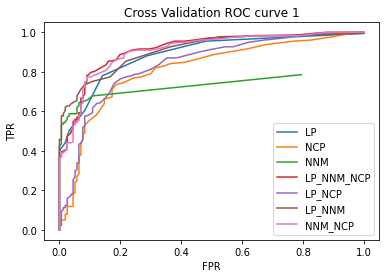

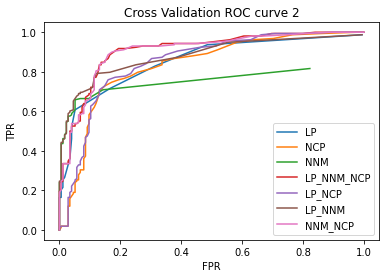

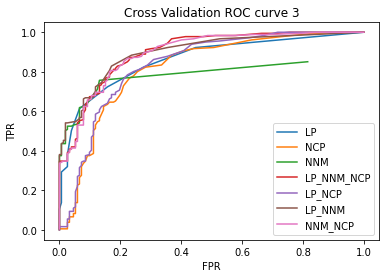

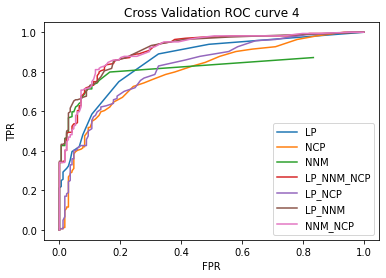

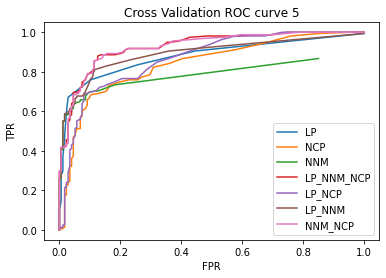

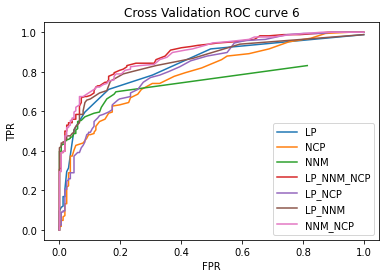

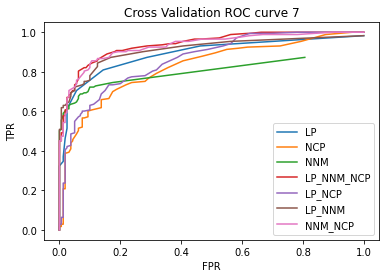

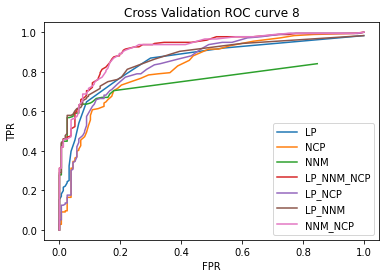

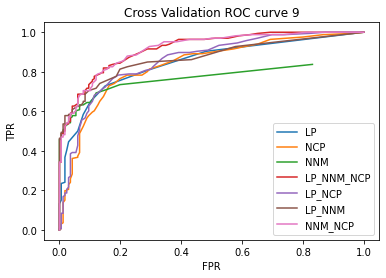

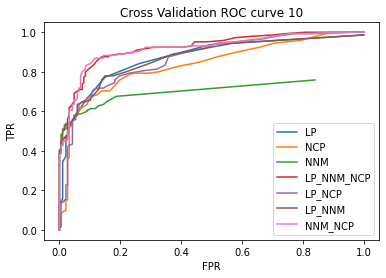

In [34]:
titles=['2CV0.jpg','2CV1.jpg','2CV2.jpg','2CV3.jpg','2CV4.jpg','2CV5.jpg','2CV6.jpg','2CV7.jpg','2CV8.jpg','2CV9.jpg','2CV10.jpg']
titles2=['Cross Validation ROC curve 1','Cross Validation ROC curve 2','Cross Validation ROC curve 3','Cross Validation ROC curve 4','Cross Validation ROC curve 5','Cross Validation ROC curve 6','Cross Validation ROC curve 7','Cross Validation ROC curve 8','Cross Validation ROC curve 9','Cross Validation ROC curve 10']
for i in range(10):
    LP_TPR, LP_FPR = tpr(testing[i], 'LP output', 'LP score')
    NNM_TPR, NNM_FPR = tpr(testing[i], 'NNM output', 'NNM score')
    NCP_TPR, NCP_FPR = tpr(testing[i], 'NCP output', 'NCP score')

    LP_NNM_NCP_TPR, LP_NNM_NCP_FPR = tpr(testing[i], 'LP_NNM_NCP output', 'LP,NNM,NCP score')
    LP_NNM_TPR, LP_NNM_FPR = tpr(testing[i], 'LP_NNM output', 'LP,NNM score')
    LP_NCP_TPR, LP_NCP_FPR = tpr(testing[i], 'LP_NCP output', 'LP,NCP score')
    NNM_NCP_TPR, NNM_NCP_FPR = tpr(testing[i], 'NNM_NCP output', 'NNM,NCP score')

    #fig = plt.figure(figsize=(15,10))    
    plt.plot(LP_FPR,LP_TPR,label='LP')
    plt.plot(NCP_FPR,NCP_TPR, label='NCP')
    plt.plot(NNM_FPR,NNM_TPR, label='NNM')
    plt.plot(LP_NNM_NCP_FPR,LP_NNM_NCP_TPR,label='LP_NNM_NCP')
    plt.plot(LP_NCP_FPR,LP_NCP_TPR, label='LP_NCP')
    plt.plot(LP_NNM_FPR,LP_NNM_TPR, label='LP_NNM')
    plt.plot(NNM_NCP_FPR,NNM_NCP_TPR, label='NNM_NCP')
    plt.title(titles2[i])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
 #   plt.savefig(titles[i],dpi=300,bbox_inches='tight')
    plt.show()

# Case Study

In a separate file, performed the model on all unknown associations and trained it on all known associations

In [36]:
unknown_associations=pd.read_csv('unknown_associations.csv')        
diseaseid_disease=dict(zip(Gold['Disease IDs(OMIM)'], Gold['Disease name']))
drugid_drug=dict(zip(Gold['Drug IDs(DrugBank)'], Gold['Drug name']))

In [40]:
def best_drug(disease):
    print(diseaseid_disease[disease])
    t={}
    df= unknown_associations.loc[unknown_associations['Disease IDs(OMIM)'] == disease].sort_values(by=['LP,NNM,NCP score'],ascending=False)[['Drug IDs(DrugBank)','LP,NNM,NCP score']].head(3)
    for index, row in df.iterrows():
            t[drugid_drug[row['Drug IDs(DrugBank)']]]=row['LP,NNM,NCP score']
    return t

def best_disease(drug):
    print(drugid_drug[drug])
    t={}
    df= unknown_associations.loc[unknown_associations['Drug IDs(DrugBank)'] == drug].sort_values(by=['LP,NNM,NCP score'],ascending=False)[['Disease IDs(OMIM)','LP,NNM,NCP score']].head(3)
    for index, row in df.iterrows():
            t[diseaseid_disease[row['Disease IDs(OMIM)']]]=row['LP,NNM,NCP score']
    return t

In [41]:
best_drug(277440.0)

vitamin d-dependent rickets, type 2a; vddr2a


{'dihydrotachysterol': 0.0792721143336117,
 'phenobarbital': 0.04478020809072891,
 'dexrazoxane': 0.04204333049780906}